## NARX SST Región Niño 3.4

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

In [ ]:
#https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
from MONGO import CONEXION
from datetime import datetime
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

# Creando Coenxión con Mongo DB

In [2]:
# Creando la conexión con MongoDB
db = CONEXION.conexion()
db.list_collection_names()

['polygons', 'meteorological', 'SSTNino34']

# Descargando la Información SST NIÑO3.4

In [3]:
# Fecha actual
time = datetime.today().toordinal()

# Realizando consulta
sst_data = db.SSTNino34.find({"time":{"$lte":time}})

# Generando pandas dataframe
data_pandas = pd.DataFrame([file for file in sst_data])
data_pandas['periodo'] = data_pandas.time.apply(lambda x: datetime.fromordinal(x))
data_pandas['mes_year'] =  data_pandas['periodo'].dt.strftime('%B-%Y')
data_pandas.index = pd.to_datetime(data_pandas.periodo)
data_pandas.head()

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022


In [4]:
# Registros
print(data_pandas.shape)

(870, 11)


In [5]:
# Data disponible
print(data_pandas.index.min())
print(data_pandas.index.max())

1950-01-01 00:00:00
2022-06-01 00:00:00


### Modelos NARX

In [6]:
# Data modelo
data_model = data_pandas[['nino34_mean']].dropna().copy()
data_model['nino34_mean_exogena'] = data_model.nino34_mean

<AxesSubplot:xlabel='periodo'>

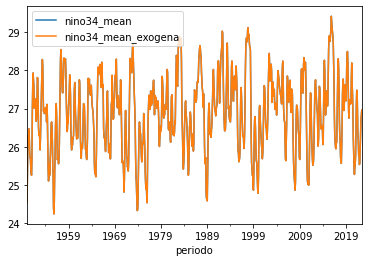

In [7]:
data_model.plot()

In [8]:
data_model.shape

(870, 2)

In [9]:
y_output = 'nino34_mean'
exogena = ['nino34_mean_exogena']

pd_model = data_model[ [y_output] + exogena].sort_index(ascending=True)
pd_model

,nino34_mean,nino34_mean_exogena
periodo,,
1950-01-01,24.56,24.56
1950-02-01,25.07,25.07
1950-03-01,25.88,25.88
1950-04-01,26.29,26.29
1950-05-01,26.19,26.19
...,...,...
2022-02-01,25.87,25.87
2022-03-01,26.32,26.32
2022-04-01,26.71,26.71


Normalización de los datos

In [10]:
t_exogena = ['t_' + x for x in exogena]
t_output = 't_' + y_output


data_mean = pd_model.mean()
data_std = pd_model.std()

pd_model[t_output] = (pd_model[y_output] - data_mean[data_mean.index==y_output][0])/data_std[data_std.index==y_output][0]

for x in exogena:
    pd_model['t_' + x] = (pd_model[x] - data_mean[data_mean.index==x][0])/data_std[data_std.index==x][0]

In [11]:
data_modelo = pd_model[[t_output]+t_exogena]
data_modelo

,t_nino34_mean,t_nino34_mean_exogena
periodo,,
1950-01-01,-2.380617,-2.380617
1950-02-01,-1.859887,-1.859887
1950-03-01,-1.032845,-1.032845
1950-04-01,-0.614219,-0.614219
1950-05-01,-0.716323,-0.716323
...,...,...
2022-02-01,-1.043056,-1.043056
2022-03-01,-0.583588,-0.583588
2022-04-01,-0.185383,-0.185383


Utilizará una división (70%, 20%, 10%) para los conjuntos de entrenamiento, validación y prueba

In [12]:
prediction_order = 12 # rango de prediccion
auto_order = 24 # componente autoregresiva
exog_order = 12 # componente exogena qm
exog_delay = 0 # componente exogena dm

In [13]:
def date_window(pd_model,auto_order,exog_order,exog_delay,exogena,output):

    X = pd_model[exogena].to_numpy().astype(float)
    y = pd_model[[output]].to_numpy().astype(float)

    # Data para el mmodelo
    input_data = []
    output_data = []
    for t in range(max(auto_order, exog_order), len(y)):
        input_data.append(np.concatenate((y[(t - auto_order + 1):(t + 1)], X[(t - exog_delay - exog_order + 1):(t - exog_delay + 1)]), axis=0) )
        output_data.append(np.array(y[t]))

    # Input del modelo
    input_data = np.array(input_data)
    # Output del modelo
    output_data = np.array(output_data)

    return (input_data,output_data)

In [14]:
# Data Test
data_test = data_modelo[:-prediction_order]
input_data, output_data = date_window(data_test,auto_order,exog_order,exog_delay,t_exogena,t_output)

print(input_data.shape)
print(output_data.shape)

(834, 36, 1)
(834, 1)


In [15]:
# Modelo en Keras
_ , ninp, _ = input_data.shape


# model definition
input_ = keras.layers.Input(shape=(ninp,))
hidden1 = keras.layers.Dense(ninp, activation="selu",kernel_initializer="lecun_normal",)(input_)
hidden2 = keras.layers.Dense(ninp, activation="selu",kernel_initializer="lecun_normal")(hidden1)
hidden3 = keras.layers.Dense(ninp, activation="selu",kernel_initializer="lecun_normal")(hidden2)
output = keras.layers.Dense(ninp)(hidden3)

# instantiate model
model = keras.models.Model(inputs=[input_],outputs=[output])

# define optimizer and learning rate
optimizer = keras.optimizers.Nadam(learning_rate = 1e-3)

# compile model to train it
model.compile(loss="mean_squared_error", optimizer=optimizer)

2022-08-07 18:30:36.086308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
history = model.fit(input_data,
                    output_data,
                    epochs=100,
                    batch_size = 32,
                    verbose = 0,
                    validation_split = 0.30)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36)]              0         
                                                                 
 dense (Dense)               (None, 36)                1332      
                                                                 
 dense_1 (Dense)             (None, 36)                1332      
                                                                 
 dense_2 (Dense)             (None, 36)                1332      
                                                                 
 dense_3 (Dense)             (None, 36)                1332      
                                                                 
Total params: 5,328
Trainable params: 5,328
Non-trainable params: 0
_________________________________________________________________


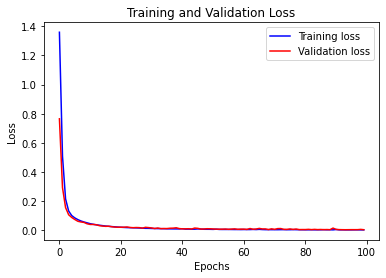

In [18]:
import matplotlib.pyplot as plt

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")